png 
  2

png 
  2

Saving 6.67 x 6.67 in image



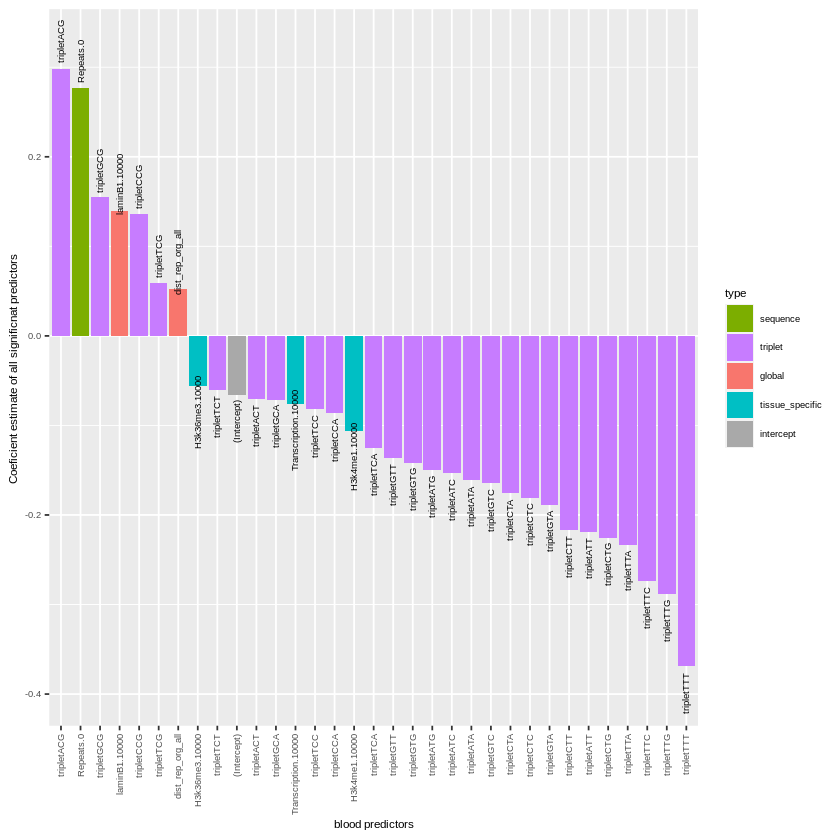

Saving 6.67 x 6.67 in image



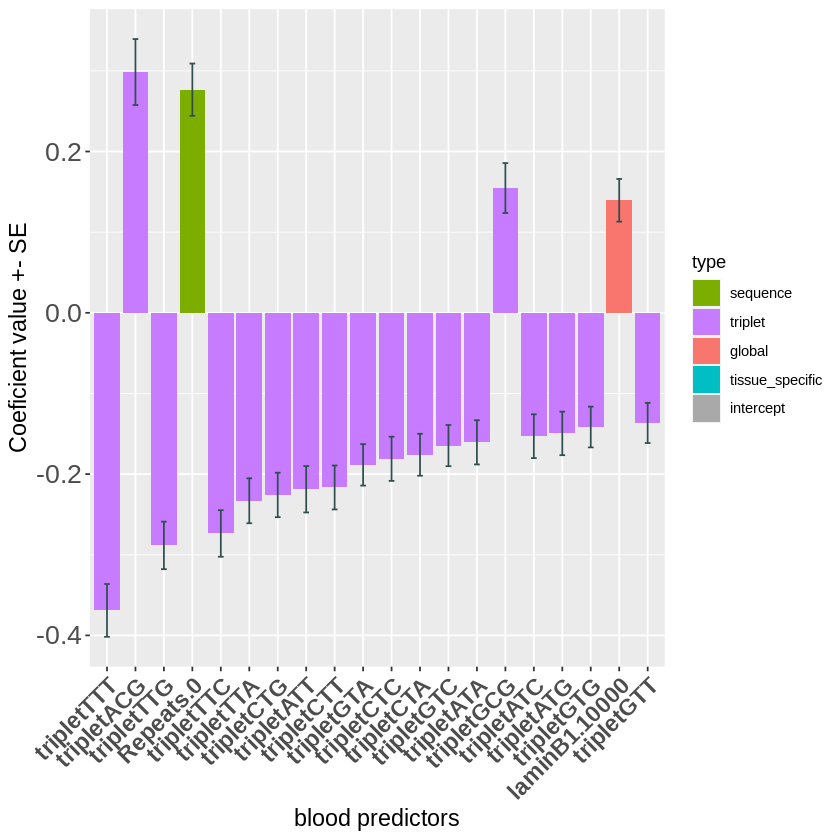

Saving 6.67 x 6.67 in image



png 
  2

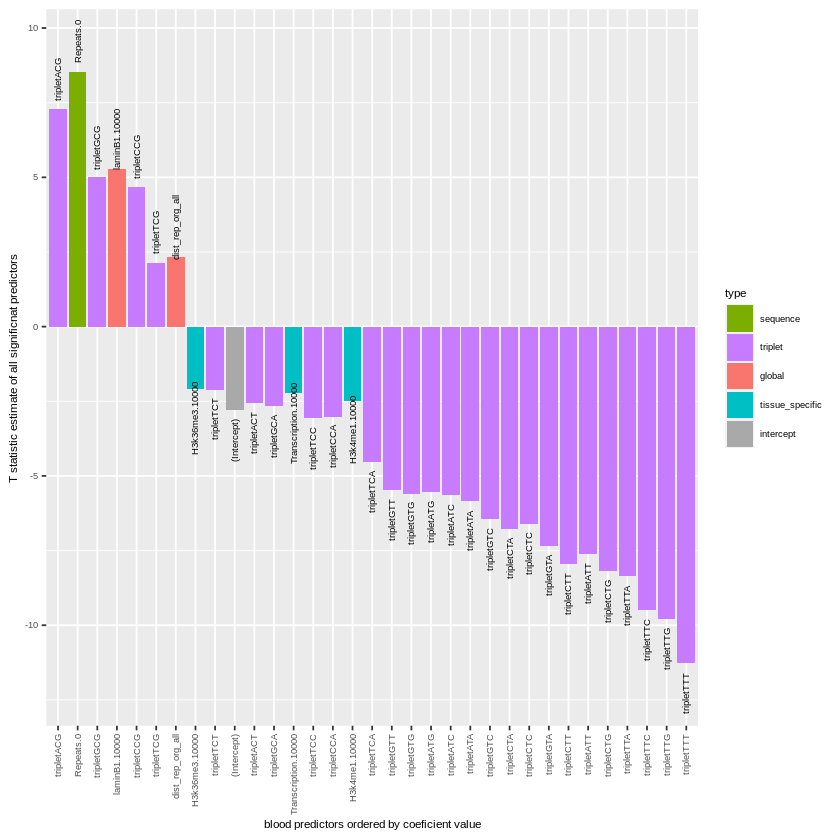

In [5]:
library(dplyr)
library(stringr)
library(stringi)
library(corrplot)
library(rlang)
library(ggplot2)

args = commandArgs(trailingOnly=TRUE)
tissue = args[1]
model_name = args[2]
n_bootstrap = as.integer(args [3])
equiv_toLowest=FALSE
exclude_CpG=FALSE
exclude_triplet=FALSE
exclude_TCX_CCX = FALSE
if ("_equiv_toLowest" %in% args){
    equiv_toLowest=TRUE
    print("equiv_toLowest=TRUE")}
if ("_exclude_CpG" %in% args){exclude_CpG=TRUE}
if ("_exclude_TCX_CCX" %in% args){exclude_TCX_CCX=TRUE}
if ("_exclude_triplet" %in% args){exclude_triplet=TRUE}

tissue = "liver"
model_name = "model9"
n_bootstrap = 0


tmp_file_path = ""

model_desc_modify = ""


if (equiv_toLowest==TRUE){
    model_desc_modify = paste(model_desc_modify,"_equiv_toLowest",sep="")}else{
    model_desc_modify = paste(model_desc_modify,"_fullModel",sep="")}
if (exclude_CpG==TRUE){
    all_data <-all_data[!str_detect(all_data$triplet,"CG"),]
    model_desc_modify = paste(model_desc_modify,"_noCpG",sep="")}
if (exclude_TCX_CCX==TRUE){
    model_desc_modify = paste(model_desc_modify,"_noTCX_CCX",sep="")}
if (exclude_triplet==TRUE){
    all_data <- all_data[,!(names(all_data) %in% c('triplet'))]
    model_desc_modify = paste(model_desc_modify,"_noTriplets",sep="")}


filename =paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_all_data_readyForPrediction",model_desc_modify,".csv", sep="")
all_data <- read.csv(filename)
all_data <- all_data[,!(names(all_data) %in% c("X","X.1"))]

#MAKING A MODEL ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
sample_sites_train <- sample (1:nrow(all_data), nrow(all_data)/2) 
sample_sites_test = c(1:nrow(all_data))[-sample_sites_train]
model <- glm(mutation_status~., data=all_data[sample_sites_train,],family="binomial")
               



                          
           
#saving the model variables 
filename = paste(tmp_file_path,"data/",tissue,"/objects/",model_name,"/",tissue,"_model",model_desc_modify,".RData", sep="") #model 
save(model, file=filename)
filename =paste(tmp_file_path,"data/",tissue,"/objects/",model_name,"/",tissue,"_samples_sites_test",model_desc_modify,".RData", sep="")#sample sites test 
save(sample_sites_test , file=filename)
filename =paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_all_data_readyForPrediction",model_desc_modify,".csv", sep="")
write.csv(all_data,filename)
                          
#checing the assumptions.. though idk how to read 
pdf(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_model_diagnostics",model_desc_modify,".pdf", sep=""))
plot(model)
dev.off() 
#checking for linearity one at a time... 
pdf(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_model_diagnostics_checkingLinearity",model_desc_modify,".pdf", sep=""))
for (pred_name in colnames(all_data)){
    plot(model$linear.predictors ~ all_data[sample_sites_train,][,pred_name],main=pred_name)
}
dev.off()

#analyze the coeficients~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#first the whole model 
coefs <- coef(summary(model))
coef_df <- as.data.frame(coefs)
colnames(coef_df) <- c("value","std_err","z_val","p_val")
coef_df$t_stat <- coef_df$value/coef_df$std_err
coef_df<- tibble::rownames_to_column(coef_df, "name") # https://stackoverflow.com/questions/29511215/convert-row-names-into-first-column
coef_df_ordered <- coef_df[order(-coef_df$value),]#https://www.statmethods.net/management/sorting.html
filename = paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_coefDF",model_desc_modify,".csv",sep="")#this sep is for the filename string
write.csv(coef_df_ordered,filename,row.names=FALSE)

coef_df_ordered <- coef_df_ordered %>%
    mutate(type = case_when(        
        str_detect(name, 'percent') ~ 'sequence',
        str_detect(name, 'Chromosome') ~ 'sequence',
        str_detect(name, 'Repeats') ~ 'sequence',
        str_detect(name, 'site') ~ 'sequence',
        str_detect(name, 'annot') ~ 'sequence',
        str_detect(name, 'content') ~ 'sequence',
        str_detect(name, 'CpG') ~ 'sequence',

        str_detect(name, 'triplet') ~ 'triplet',

        str_detect(name, 'DNAse') ~ 'tissue_specific',
        str_detect(name, 'Transcription') ~ 'tissue_specific',
        str_detect(name, 'H3k') ~ 'tissue_specific',
        str_detect(name, 'methyl') ~ 'tissue_specific',

        str_detect(name, 'recomb') ~ 'global',
        str_detect(name, 'lamin') ~ 'global',
        str_detect(name, 'Replication') ~ 'global',
        str_detect(name, 'dist_rep') ~ 'global',

        str_detect(name, 'Intercept') ~ 'intercept',
    ))
stopifnot(nrow(coef_df_ordered[is.na(coef_df_ordered$type),])==0)#making sure all column names have a type

#GGPLOT PLOTTING THE COEF VALUES ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
#setting the colors for each predictor type 
colors_ggplot <- c(sequence = "#7CAE00", triplet = "#C77CFF", global ='#F8766D', tissue_specific = '#00BFC4', intercept = "darkgrey")# https://stackoverflow.com/questions/17180115/manually-setting-group-colors-for-ggplot2


#bar plot of all the coefs 
ggplot(coef_df_ordered[coef_df_ordered$p_val<0.05,], aes(x = reorder(name, -value), y = value,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste(tissue,"predictors",sep=" "))+
    ylab("Coeficient estimate of all significnat predictors ")+
    #https://www.tutorialspoint.com/how-to-display-negative-labels-below-bars-in-barplot-using-ggplot2-in-r
    geom_text(aes(y=value+0.03*sign(value),label=name),angle = 90,size=2)+#bars next to bar value 
    #geom_text(aes(y=-0.05*sign(mean_est),label=name),angle = 90,size=2)+#labels next to the bottom (0 line) of bars 
    theme(text = element_text(size=7),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
#     scale_fill_manual(values=c(orange_ggplot,"darkgrey", green_ggplot, blue_ggplot,purple_ggplot))
    scale_fill_manual(values=colors_ggplot)
 ggsave(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_coef_barplot_all",model_desc_modify,".pdf",sep=""))
#bar plot of the top 20 predictors 
coef_df_ordered_top10 <- head(coef_df_ordered[order(-abs(coef_df_ordered$value)),],n=20)
ggplot(coef_df_ordered_top10, aes(x = reorder(name, -abs(value)), y = value,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste(tissue,"predictors",sep=" "))+
    ylab("Coeficient value +- SE")+ 
    theme(axis.text.x = element_text(angle = 45, vjust = 1, hjust=1,size=14),axis.text.y = element_text(size=16))+
    theme(axis.title=element_text(size=14))+
    scale_fill_manual(values=colors_ggplot)+
    geom_errorbar(aes(ymin=value-std_err, ymax=value+std_err), width=.2,position=position_dodge(.9),color="darkslategrey")+ #http://www.sthda.com/english/wiki/ggplot2-error-bars-quick-start-guide-r-software-and-data-visualization
    theme(axis.text.x = element_text(face="bold", size=14, angle=45))
ggsave(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_coef_barplot_top20",model_desc_modify,".pdf",sep=""))

#NOW FOR THE T STATISTIC 
ggplot(coef_df_ordered[coef_df_ordered$p_val<0.05,], aes(x = reorder(name, -t_stat), y = t_stat,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste(tissue,"predictors",sep=" "))+
    ylab("T statistic estimate of all significnat predictors ")+
    #https://www.tutorialspoint.com/how-to-display-negative-labels-below-bars-in-barplot-using-ggplot2-in-r
    geom_text(aes(y=t_stat+1*sign(t_stat),label=name),angle = 90,size=2)+#bars next to bar value 
    #geom_text(aes(y=-0.05*sign(mean_est),label=name),angle = 90,size=2)+#labels next to the bottom (0 line) of bars 
    theme(text = element_text(size=7),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
#     scale_fill_manual(values=c(orange_ggplot,"darkgrey", green_ggplot, blue_ggplot,purple_ggplot))
    scale_fill_manual(values=colors_ggplot)
 ggsave(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_tstat_barplot_all",model_desc_modify,"_0.05.pdf",sep=""))

ggplot(coef_df_ordered[coef_df_ordered$p_val<0.01,], aes(x = reorder(name, -t_stat), y = t_stat,fill=type))+
    geom_bar(stat="identity")+
    xlab(paste(tissue,"predictors",sep=" "))+
    ylab("T statistic estimate of all significnat predictors ")+
    #https://www.tutorialspoint.com/how-to-display-negative-labels-below-bars-in-barplot-using-ggplot2-in-r
    geom_text(aes(y=t_stat+1*sign(t_stat),label=name),angle = 90,size=2)+#bars next to bar value 
    #geom_text(aes(y=-0.05*sign(mean_est),label=name),angle = 90,size=2)+#labels next to the bottom (0 line) of bars 
    theme(text = element_text(size=7),axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1))+
#     scale_fill_manual(values=c(orange_ggplot,"darkgrey", green_ggplot, blue_ggplot,purple_ggplot))
    scale_fill_manual(values=colors_ggplot)
 ggsave(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_tstat_barplot_all",model_desc_modify,"_0.01.pdf",sep=""))






png 
  2

# **scratch**

# **scratch**

# **scratch**

# **scratch**

# testing that the output fo the t stat df output is correct 

In [3]:
test_df <- read.csv("../../../data/liver/dataframes/model7//liver_Tstat_DF_bootstrap_bloodEquiv.csv")

In [23]:
rowMeans(test_df[,7:106]) == apply(select(test_df,contains("t_stat_")),1,sd)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [31]:
round(apply(test_df[,7:106],1,sd),5) == round(test_df$stdDev_Tstat,5)

[1] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[16] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[31] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[46] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE
[61] TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE TRUE

In [28]:
test_df$mean_Tstat

[1] -3.34090073 -0.06764886 -0.76412572  0.53384205  1.08552897 -0.22432027
 [7] -0.63733832  1.72390332  0.85771586  2.01593937  0.34429452 -0.60818486
[13] -1.10307350  0.54976684  0.39344036  0.64110471 -0.32800153 -0.33645264
[19]  1.41117360 -1.05232731  0.08535398 -0.38080840 -0.33486122  1.00354472
[25]  0.94273743  1.08123809  1.06855718 -0.82089430  3.27242991 -0.13270577
[31] -0.60028577 -5.14480362  0.96294037 -1.99339264 -1.11909394 -0.28071024
[37]  0.58070775 -0.94440754  1.71233810 -1.07671713 -0.05340529 -0.59622667
[43]  1.19340026 -0.62581164  1.65716744  6.84816650  0.55691454  0.58587407
[49] -1.22783236  0.98910480 -1.53101023  1.49460607  1.97137090  5.02660914
[55]  1.46398871 -3.76496195 -5.29749186 -1.94738297 -4.70506001  0.70026595
[61]  0.48749063  5.18781499  0.53563453 -1.91005048 -2.68513400 -2.22564014
[67] -1.50939254  0.95822155  1.66651659  3.52445899  0.83990175 -4.35786205
[73] -5.08639069 -3.25403572 -6.32439045

In [10]:
head(test_df)

,name,value,std_err,z_val,p_val,t_stat,t_stat_1,t_stat_2,t_stat_3,t_stat_4,⋯,t_stat_94,t_stat_95,t_stat_96,t_stat_97,t_stat_98,t_stat_99,t_stat_100,mean_Tstat,stdDev_Tstat,stdErr_Tstat
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,(Intercept),-0.097435926,0.02298913,-4.2383483,2.251702e-05,-4.2383483,-6.119648,-4.3663241,-4.1779230,-4.8900372,⋯,-3.9629252,-3.9993417,-4.2020299,-4.6057968,-4.201196563,-4.5834856,-4.2242931,-3.34090073,1.6369723,0.16369723
2,annotationtranscribed,-0.003625900,0.02358648,-0.1537279,8.778243e-01,-0.1537279,-1.615434,-0.6760275,-0.6910201,0.1520551,⋯,-1.0897532,2.7107133,0.5639277,-0.3351701,-0.768247135,-0.0552240,-1.0788768,-0.06764886,1.1043145,0.11043145
3,annotationUTR3,-0.018472273,0.02359051,-0.7830382,4.336047e-01,-0.7830382,-1.115121,-1.5986562,-2.1038943,-2.2634476,⋯,-0.4831527,-0.7672766,-1.0531934,-0.8402686,-0.005807481,0.1784535,1.0318728,-0.76412572,0.9337345,0.09337345
4,annotationUTR5,0.013284277,0.02237013,0.5938400,5.526191e-01,0.5938400,2.712375,0.8137773,1.3348665,3.0531267,⋯,1.8753810,1.9866965,-1.0344119,-0.3344962,0.120361202,0.2480341,0.6193108,0.53384205,0.9979384,0.09979384
5,Chromosomechr10,0.033856840,0.02907698,1.1643865,2.442674e-01,1.1643865,1.408826,0.4565067,-0.3695308,-0.6113703,⋯,0.1939452,0.5957810,0.1253341,3.1001244,0.453499016,1.0343960,2.0845492,1.08552897,1.0696152,0.10696152
6,Chromosomechr11,-0.004769142,0.02911331,-0.1638131,8.698783e-01,-0.1638131,-1.393117,0.2974414,-0.4914425,-0.6267762,⋯,-0.7935224,-1.0963196,-0.5590863,1.2357242,-1.198903258,1.9374065,0.1311709,-0.22432027,0.9324854,0.09324854


In [15]:
apply(select(Tstat_df,contains("t_stat_")),1,sd)

[1] 0.30846767 0.01110336 0.99941182 0.88230515 0.90079216 1.12403555
 [7] 1.05861186 1.07760027 0.89856380 1.04957568 0.98873990 1.01146858
[13] 1.05967308 0.95915683 1.10381400 1.07054726 0.97299737 1.00126262
[19] 1.07675167 1.07241627 1.06149177 1.05370315 1.05563227 1.05545255
[25] 1.05382600 0.99937659 0.76028149 0.73982007 1.09802114 1.02747590
[31] 0.96601300 1.10988053 1.04562102 1.04650563 0.96157397 1.06166252
[37] 0.96477433 0.99375096 0.91709602 1.02151716 0.94944147 1.02067220
[43] 1.12769988 0.89226727 0.90593647 1.05611677 0.71782153 1.19065711
[49] 1.04823005 1.11771993 0.95953021 1.10941619 0.98502954 0.94430035
[55] 0.94351929 1.07051739 0.97663620 0.95728550 0.95745236 1.09638092
[61] 1.06608284 1.09582502 0.74491216 1.06042996 0.97584021 0.89824994
[67] 0.98833394 0.99873311 1.15848160 1.11526751 0.73303574 1.12391530
[73] 1.02264743 1.03622221 0.95909967 1.04972391

# **scratch**

In [ ]:

# args = commandArgs(trailingOnly=TRUE)
# tissue = args[1]
# model_name = args[2]
# n_bootstrap = as.integer(args [3])
# equiv_toLowest=FALSE
# exclude_CpG=FALSE
# exclude_triplet=FALSE
# exclude_TCX_CCX = FALSE
# if ("equiv_toLowest" %in% args){
#     equiv_toLowest=TRUE
#     print("equiv_toLowest=TRUE")}
# if ("exclude_CpG" %in% args){exclude_CpG=TRUE}
# if ("exclude_TCX_CCX" %in% args){exclude_TCX_CCX=TRUE}
# if ("exclude_triplet" %in% args){exclude_triplet=TRUE}
# tissue = "skin"
# model_name = "model8"
# equiv_toLowest=TRUE
# exclude_CpG=FALSE 
# exclude_triplet=FALSE
# exclude_TCX_CCX = FALSE

# tmp_file_path = "../../../"
# options(warn=1)


# model_desc_modify = ""
# #import the data 
# input_filePath = paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/predictorDf.txt",sep="")
# all_data <- read.table(input_filePath, header = TRUE,sep="\t")



# if (equiv_toLowest==TRUE){
# #     blood_nrow = nrow(read.table(paste(tmp_file_path,"data/blood/dataframes/",model_name,"/predictorDf.txt",sep=""),header = TRUE,sep="\t"))
#     blood_nrow = 17814
#     all_data <-all_data[sample(nrow(all_data), blood_nrow), ]
#     model_desc_modify = paste(model_desc_modify,"_bloodEquiv",sep="")}
# print(nrow(all_data))
# if (exclude_CpG==TRUE){
#     all_data <-all_data[!str_detect(all_data$triplet,"CG"),]
#     model_desc_modify = paste(model_desc_modify,"_noCpG",sep="")}
# if (exclude_TCX_CCX==TRUE){
#     model_desc_modify = paste(model_desc_modify,"_noTCX_CCX",sep="")}


# # print(summary(as.factor(all_data$triplet)))
# if (exclude_triplet==TRUE){
#     all_data <- all_data[,!(names(all_data) %in% c('triplet'))]
#     model_desc_modify = paste(model_desc_modify,"_noTriplets",sep="")}
# print(model_desc_modify)
# print(colnames(all_data))

# #setting up the error output file 
# error_output_file = paste(tmp_file_path,"data/",tissue,"/objects/",model_name,"/",tissue,"_create_model_text_output",model_desc_modify,".txt",sep="")
# cat("output for the create_model notebook",file=error_output_file,sep="\n")

#chnaging the 1-surround to 0 surround (--> due to a mess up, only blood )
# if (tissue=="blood"){
#     all_data <- all_data %>% 
#   rename(Apercent.0=Apercent.1,Gpercent.0=Gpercent.1,Cpercent.0=Cpercent.1,Tpercent.0=Tpercent.1,
#          methylation_coverage.0=methylation_coverage.1,methylation_precent.0=methylation_precent.1,
#          H3k27.0=H3k27.1,H3k27me3.0=H3k27me3.1,H3k4me1.0=H3k4me1.1,H3k4me3.0=H3k4me3.1,H3k36me3.0=H3k36me3.1,
#          Transcription.0=Transcription.1,recombination.0=recombination.1,Repeats.0=Repeats.1,DNAse.0=DNAse.1,laminB1.0=laminB1.1)
# }

#remove the protein binding flag (if it exists in the version of the predictor data: not existant in later versions)
# all_data$annotation <- gsub("protein_binding","not_transcribed",all_data$annotation)#there are so few protein binding sites that we may as well omit 

# #removing unamppable points 
# mappable_mut_summary <- all_data %>% 
#     group_by(mappability,mutation_status)%>%
#     summarise(count=n())
# unmapped_muts = (filter(mappable_mut_summary, (mappability == "not")&(mutation_status == 1))$count)
# unmapped_nonMuts = (filter(mappable_mut_summary, (mappability == "not")&(mutation_status == 0))$count)
# string_to_print = paste(tissue,":",unmapped_muts," mutations and",unmapped_nonMuts,"nonMut sites removed by mappability filter out of ",nrow(all_data),"sites",sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
# all_data <- filter(all_data,mappability=="mappable")
# all_data <- all_data[,!(names(all_data) %in% c("mappability"))]

#gc content 
# all_data <- all_data %>%
#     mutate(GC_content.0 = Gpercent.0+Cpercent.0) %>%
#     mutate(GC_content.100 = Gpercent.100+Cpercent.100) %>% 
#     mutate(GC_content.10000 = Gpercent.10000+Cpercent.10000)
# all_data <- all_data[,!(names(all_data) %in% c('Apercent.0','Gpercent.0','Cpercent.0','Tpercent.0',
#                                        'Apercent.100','Gpercent.100','Cpercent.100','Tpercent.100',
#                                        'Apercent.10000','Gpercent.10000','Cpercent.10000','Tpercent.10000'))]

# #editing the triplets 
# if (exclude_triplet==FALSE){
#     all_data$triplet <- toupper(all_data$triplet)
#     #filter for rows that dont have NNN as the triplet --> write the details to file 
#     cat(paste(nrow(all_data[all_data$triplet == "NNN",]), "rows removed due to N in triplet, ",sep=" "),file=error_output_file,sep="\n",append=TRUE)
#     all_data <- all_data[all_data$triplet != "NNN",]
#     cat(paste(nrow(all_data),"rows left",sep=" "),file=error_output_file,sep="\n",append=TRUE)
# }


# #create df to test coverage in the methylation download notebook 
# bases = c("A","T","C","G")
# c_trips = c()
# for (b1 in bases){
#     for (b3 in bases){
#         c_trips <- append(c_trips,paste(b1,"C",b3,sep=""))
#     }
# }
# if (exclude_triplet==FALSE){
#     c_trips_df <- filter(all_data, triplet%in%c_trips)[,c("Chromosome","site","triplet",'methylation_precent.0','methylation_coverage.0')]
#     write.csv(c_trips_df,paste(tmp_file_path,"data/",tissue,"/track_data/methylation/predDf_ctrips",model_desc_modify,".csv",sep=""))
# }



# all_data <- all_data %>% 
#       mutate(methylable = ifelse((methylation_precent.0=="no_percent_data" & GC_content.0 == 0), "no",#not a C/G site = no 
#                ifelse((methylation_precent.0=="no_percent_data" & GC_content.0 == 1), NA, # C/G site with no data = NA 
#                ifelse(methylation_precent.0=="0.0","no","yes")))) #C/G site with 0 = no, >0 = yes 



# #REMOVING METHYLATION COLUMN
# all_data <- all_data[,!(names(all_data) %in% c("site","methylation_precent.0","methylation_precent.100","methylation_precent.10000",
#                                                "methylation_coverage.0","methylation_coverage.100","methylation_coverage.10000","methylableyes"))]
# all_data <- all_data[!(is.na(all_data$methylable)),] #getting rid of the methylation nas 




# #how many mutations and sites 
# #printing the mutation ratio to file 
# string_to_print = paste("mut/normal ratio: ",nrow(all_data[all_data$mutation_status == "1",])/nrow(all_data),sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
# #printing the total mutations included to file 
# string_to_print = paste("n muts = ", nrow(all_data[all_data$mutation_status == "1",]),sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
# #printing the total rows included to file 
# string_to_print = paste("total nrow", nrow(all_data),sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)


# #converting 64-->32 triplets 
# if (exclude_triplet==FALSE){
#     rc_removeAG <- function(dna){
#         middle_base = substr(dna, 2, 2)
#         if(middle_base %in% c("A","G")){
#             dna <- stri_reverse(chartr("acgtACGT", "tgcaTGCA", dna))}
#         return(dna)
#     }#substring slicing https://www.johnmyleswhite.com/notebook/2009/02/25/text-processing-in-r/
#     all_data$triplet <- unlist(lapply(as.character(all_data$triplet),rc_removeAG)) #need unlistto turn the list into a vector 
# }

# if (exclude_TCX_CCX==TRUE){
#     all_data <-all_data[!str_detect(all_data$triplet,"[TC]C[ATCG]"),]}

# #check for problems with levels / column tye etc. 
# if (exclude_triplet==FALSE){
#     all_data$triplet <- as.character(all_data$triplet) #need to convert to char so the as.factor properly reducs to 64 levels after the removal of 'triplets" longer than 3
#     string_to_print = paste(nrow(all_data[nchar(as.character(all_data$triplet))!=3,]),"rows removed due to triplet larger than 3 in length ",sep=" ")
#     cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
#     all_data <- all_data[nchar(all_data$triplet)==3,] #make sure only including triplets 
#     string_to_print=paste(nrow(all_data)," rows left", sept = " ")
#     cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
# }

#editing the annotation colun --> ignored into non_transcribed 
# all_data$annotation <- gsub("ignored","not_transcribed",all_data$annotation)
# all_data$annotation <- gsub("protein_binding","not_transcribed",all_data$annotation)#there are so few protein binding sites that we may as well omit 
# #rerplacing with "not_transcribed" is fine as they are the last level before non_transcribed in the annotation module 

# #factorizing the columns 
# all_data$mutation_status <- as.factor(all_data$mutation_status)
# if (exclude_triplet==FALSE){all_data$triplet <- as.factor(as.character(all_data$triplet))}
# all_data$Chromosome <- as.factor(all_data$Chromosome)
# all_data$annotation <- as.factor(all_data$annotation)
# all_data$CpGisland <- as.factor(all_data$CpGisland)
# all_data$methylable <- as.factor(all_data$methylable)

# #checking that the factor variables are correct (mutation status, triplets, chroms) --> will raise error if not true 
# stopifnot(length(levels(all_data$mutation_status)) == 2)
# if (exclude_triplet==FALSE){
#     if(exclude_CpG==TRUE&exclude_TCX_CCX==FALSE){
#         stopifnot(length(levels(all_data$triplet))==28)}
#     if(exclude_CpG==FALSE&exclude_TCX_CCX==TRUE){
#         stopifnot(length(levels(all_data$triplet))==24)}
#     if(exclude_CpG==TRUE&exclude_TCX_CCX==TRUE){
#         stopifnot(length(levels(all_data$triplet))==22)}
#     if(exclude_CpG==FALSE&exclude_TCX_CCX==FALSE){
#         stopifnot(length(levels(all_data$triplet))==32)}}
# stopifnot(length(levels(all_data$Chromosome))==22)
# stopifnot(length(levels(all_data$CpGisland))==3)
# stopifnot(length(levels(all_data$methylable))==2)

# #if germline, then edit out the female and make the male the default ( i used to include both female and male) 
# if (tissue == "germline"){
#     all_data <- select(all_data,-matches("female")) 
#     colnames(all_data)<- str_replace_all(colnames(all_data), "_male", "")
# }

# #na omit and checking how many rows were removed 
# string_to_print = paste(nrow(all_data)- nrow(na.omit(all_data)), "lost to NA values, ", nrow(na.omit(all_data))," rows remain after",sep=" ")
# cat(string_to_print,file=error_output_file,sep="\n",append=TRUE)
# all_data <- na.omit(all_data)

# #writing frequencies and counts for the categories of factor predictors 
# #get he factor names 
# factor_names <- names(Filter(is.factor,all_data))
# factor_names <-factor_names[ !factor_names == 'mutation_status']
# #for loop to print for each factor 
# predictor_freqs_count_filePath <- paste(tmp_file_path,"data/",tissue,"/objects/",model_name,"/",tissue,"_create_model_predFreqs",model_desc_modify,".csv",sep="")
# cat("predictor,category,frequency,n_sites",file=predictor_freqs_count_filePath,sep="\n")
# for (predictor_name in factor_names){
# #     string_to_print<-(paste(predictor_name," mutation distributions",sep=" "))
# #     cat(string_to_print,file=predictor_freqs_count_filePath,sep="\n",append=TRUE)
#     test_df<-as.data.frame(table(all_data[,"mutation_status"], all_data[,predictor_name]))#https://stackoverflow.com/questions/14596420/how-to-get-value-by-column-name-in-r
#     colnames(test_df) <- c("mut_stat",predictor_name,"Freq")
#     for (cur_annot in levels(all_data[,predictor_name])){
#         n_sites = sum(test_df[test_df[predictor_name]==cur_annot,]$Freq)
#         n_muts <- as.integer(test_df[test_df[predictor_name]==cur_annot&test_df["mut_stat"]=="1"][3])#the third colun is the one with the count 
#         string_to_print <-((paste(predictor_name,cur_annot,n_muts/n_sites,n_sites,sep=",")))
#         cat(string_to_print,file=predictor_freqs_count_filePath,sep="\n",append=TRUE)}}

# #distributions ~~~~~~~~~~~~~~~~~~~~~
# #getting only numeric 
# num_cols <- colnames(all_data[,unlist(lapply(all_data, is.numeric), use.names = FALSE)])#https://stackoverflow.com/questions/5863097/selecting-only-numeric-columns-from-a-data-frame

# pdf(paste(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_predictor_distributions",model_desc_modify,".pdf", sep="")))
# for (cur_pred in num_cols){
#     cur_data = all_data[,cur_pred]
#     title = paste(cur_pred,"\nsd:",round(sd(cur_data),digits=2), " mean:", round(mean(cur_data),digits=2), " median:",round(median(cur_data),digits=2)," min,max:",round(min(cur_data),digits=5),",",max(round(cur_data,digits=2)))
#     hist(cur_data, main=title,breaks=20)
# }
# dev.off()
# pdf(paste(paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_predictor_distributions_remove0",model_desc_modify,".pdf", sep="")))
# for (cur_pred in num_cols){
#     cur_data = filter(all_data,!!sym(cur_pred)>0)[,cur_pred]# get r to handle strign as value https://stackoverflow.com/questions/48219732/pass-a-string-as-variable-name-in-dplyrfilter
#     title = paste(cur_pred,"\nsd:",round(sd(cur_data),digits=2), " mean:", round(mean(cur_data),digits=2), " median:",round(median(cur_data),digits=2)," min,max:",round(min(cur_data),digits=5),",",max(round(cur_data,digits=2)))
#     hist(cur_data, main=title,breaks=20)
# }
# dev.off()

# #making categorical columns into seperate numerical columns ready for standardizing 
# all_data$dummy <- 1#need a dumym column that the model.matrix can remove (as it has to remove a column aparently)
# muts_col <- all_data$mutation_status#saving the column of mutations so i can add it back later 
# non_num_preds = c("mutation_status")
# preds_to_standardize<-!(names(all_data) %in% non_num_preds)
# all_data <-(data.frame((model.matrix(dummy~., all_data[, preds_to_standardize])[,-1] )))
# all_data$mutation_status <- muts_col


# #STANDARDIZING~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# non_num_preds = c("mutation_status")
# preds_to_standardize<-!(names(all_data) %in% non_num_preds)#yes i have to do this again because i chnaged the order of the mutant column 
# all_data[, preds_to_standardize]<- (as.data.frame(scale(all_data[, preds_to_standardize],center=TRUE,scale=TRUE)))




#creating and saving the corplot 
# # num_data <- na.omit(subset(all_data, select=-c(Chromosome,triplet,annotation,CpGisland))) --> dont need this anymore as correlating ther categoricals too 
# num_data <-all_data
# num_data$mutation_status <- as.numeric(num_data$mutation_status)
# num_cor <- cor(num_data)
# filename = paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_corPlot",model_desc_modify,".pdf", sep="")
# pdf(filename)
# corrplot(num_cor,method = "color",type="upper",number.cex=0.5,tl.cex = 0.5,main=tissue)
# dev.off() 

# #CORRELATION ANALYSIS ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# #create the correlation df and 
# cor_df <- as.data.frame(which(num_cor >=0.8,arr.ind=T))
# cor_df$col_name <- colnames(num_cor)[cor_df$col]  #insert tyhe col names 
# testFunc <- function(a, b) round(num_cor[a,b],digits=3)#https://stackoverflow.com/questions/15059076/call-apply-like-function-on-each-row-of-dataframe-with-multiple-arguments-from-e
# cor_df$cor_val <- apply(cor_df[,c('row','col')], 1, function(y) testFunc(y['row'],y['col'])) #insert the value of the correlatnio 
# #exclude the self corelations and convert row names into a col 
# cor_df<- filter(as.data.frame(cor_df),row!=col)[,c("col_name","cor_val")]
# cor_df<- tibble::rownames_to_column(cor_df, "row_name")
# #reorder the var names into alphabetical order 
# testFunc <- function(a,b) paste(str_sort(c(a,b)),sep="-")[1]
# cor_df$first_name <- apply(cor_df,1,function(y) testFunc(y['row_name'],y['col_name']))
# testFunc <- function(a,b) paste(str_sort(c(a,b)),sep="-")[2]
# cor_df$last_name <- apply(cor_df,1,function(y) testFunc(y['row_name'],y['col_name']))
# #subset cols
# cor_df <- cor_df[,c("first_name","last_name","cor_val")]
# #doing soem strign replace to maker the distinct below applicable 
# cor_df <- data.frame(lapply(cor_df, function(x) {gsub("1[.]1", "1", x)}))
# cor_df <- data.frame(lapply(cor_df, function(x) {gsub("[.]2", "", x)}))
# cor_df <- data.frame(lapply(cor_df, function(x) {gsub("0[.]1", "0", x)}))
# #remove the duplicates and reorder for legibility 
# cor_df <- distinct(cor_df)
# cor_df <- cor_df[order(cor_df$first_name),]
# #save to file 
# filename = paste(tmp_file_path,"data/",tissue,"/dataframes/",model_name,"/",tissue,"_fullModel_corTable_above0.8",model_desc_modify,".csv", sep="")
# write.csv(cor_df,filename, row.names = FALSE)
                          
# #REMOVING CORRELATED VARIABLES 
# correlated_vars_toRm = c('H3k27.1','H3k27.0','H3k27.100',
#                          'H3k4me1.0','H3k4me1.1','H3k4me1.100',
#                          'H3k4me3.0','H3k4me3.1','H3k4me3.100',
#                          'H3k27me3.0','H3k27me3.1','H3k27me3.100',
#                          'H3k36me3.0','H3k36me3.1','H3k36me3.100',
#                          "Transcription.0","Transcription.1","Transcription.100",
#                          "recombination.0","recombination.1","recombination.100",
#                          "DNAse.0","DNAse.1","DNAse.10000",
#                          "GC_content.0",
#                          "Repeats.100")
# all_data <- all_data[,!(names(all_data) %in% correlated_vars_toRm)]
# #redoing rhe corplot after emoving correlations 

# num_data <-all_data
# num_data$mutation_status <- as.numeric(num_data$mutation_status)
# num_cor <- cor(num_data)
# filename = paste(tmp_file_path,"analysis/",tissue,"/plots/",model_name,"/",tissue,"_corPlot_pruned",model_desc_modify,".pdf", sep="")
# pdf(filename)
# corrplot(num_cor,method = "color",type="upper",number.cex=0.5,tl.cex = 0.5,main=tissue)
# dev.off()